<a href="https://colab.research.google.com/github/ella00100/Kaggle_competition/blob/main/Porto%2002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c porto-seguro-safe-driver-prediction
!ls

Saving kaggle.json to kaggle.json
 95% 73.0M/76.5M [00:01<00:00, 57.2MB/s]
100% 76.5M/76.5M [00:01<00:00, 66.0MB/s]
kaggle.json  porto-seguro-safe-driver-prediction.zip  sample_data


In [3]:
!unzip porto-seguro-safe-driver-prediction.zip

Archive:  porto-seguro-safe-driver-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
#trian 데이터 확인
rows = train.shape[0]
columns = train.shape[1]
print(f"The train dataset contains {rows} rows and {columns} columns")

The train dataset contains 595212 rows and 59 columns


# Data Quality checks
null or missing values check



In [7]:
#null 데이터 확인
train.isnull().any().any()

False

null 데이터는 없다고 나왔지만, 실제로는 null 데이터가 -1로 표시되어있습니다. 


In [8]:
#train데이터를 복제해서 -1을 null로 변경
train_copy = train
train_copy = train_copy.replace(-1, np.NAN)

<Axes: >

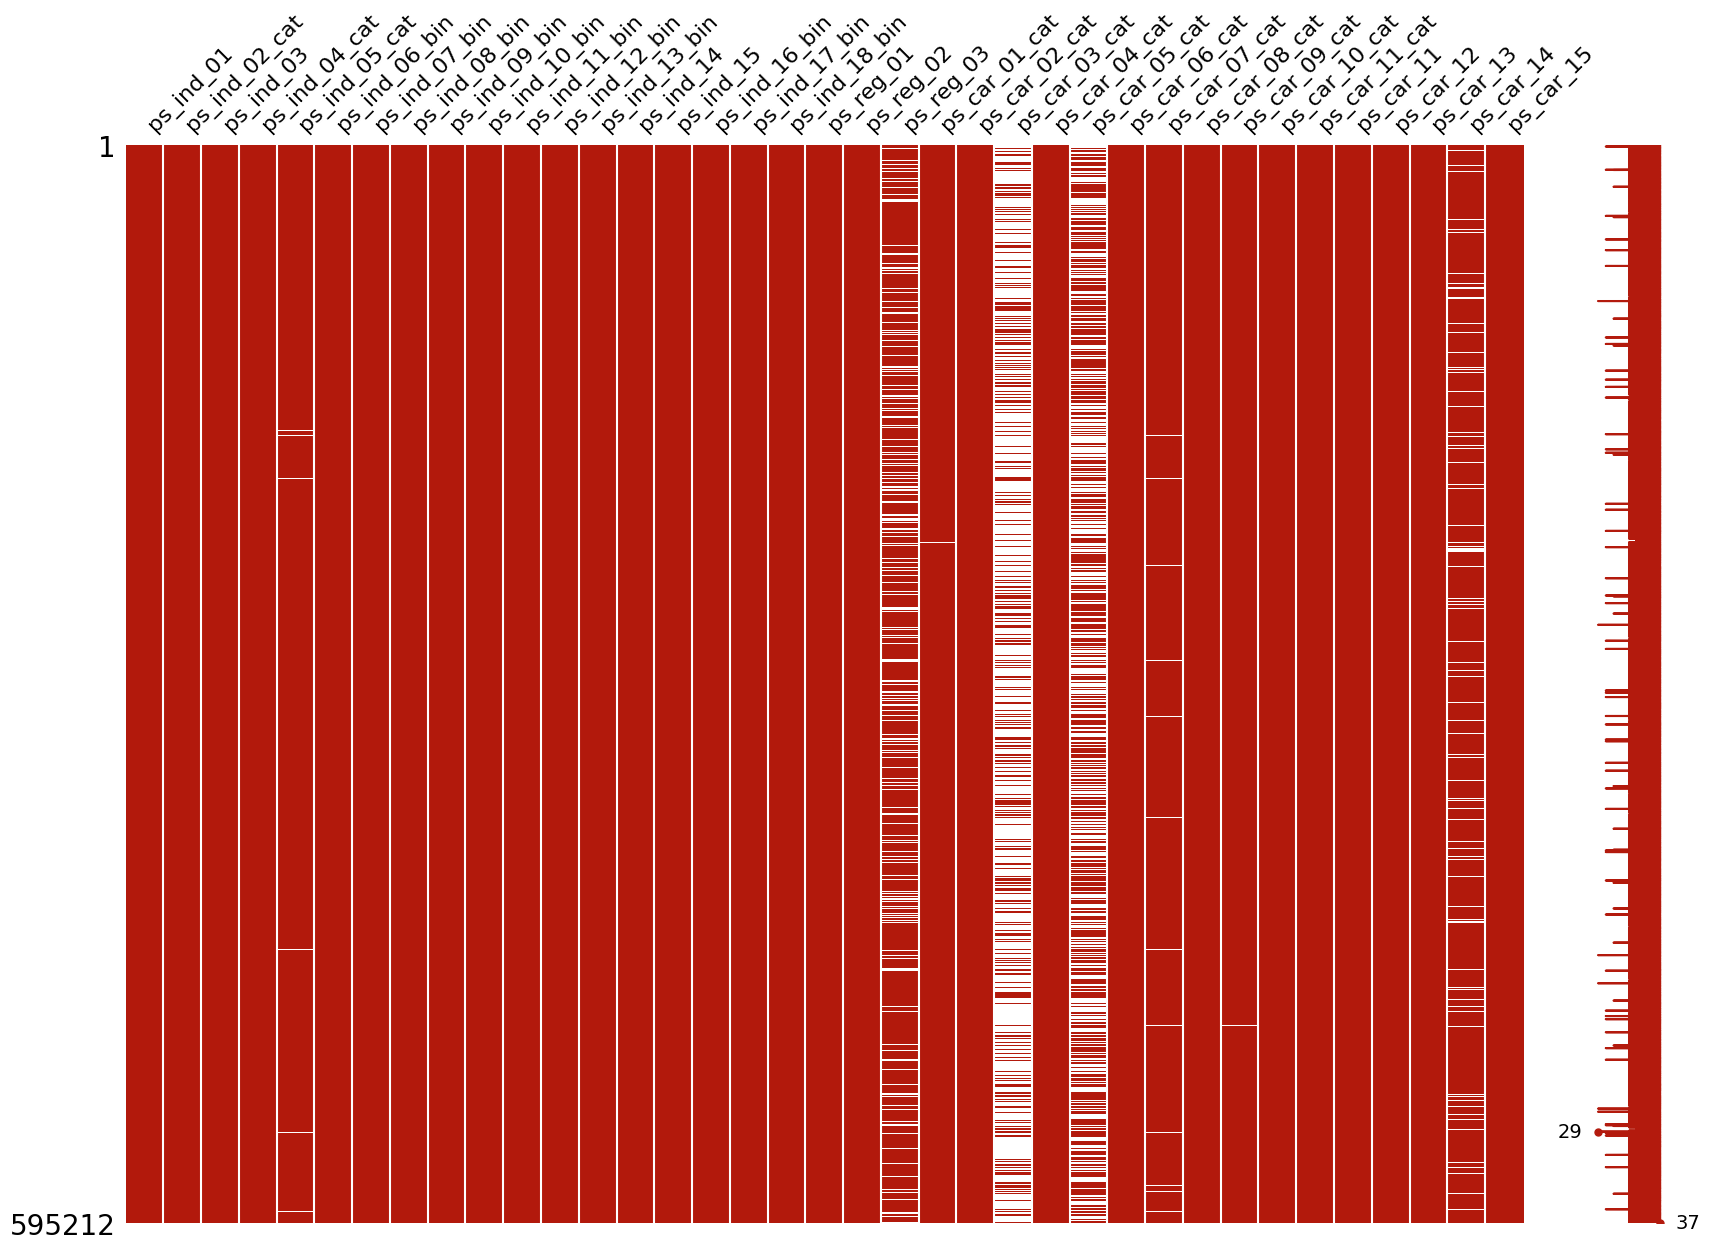

In [12]:
import missingno as msno
msno.matrix(df=train_copy.iloc[:,2:39], figsize=(20,14), color=(0.7, 0.1, 0.05))

- 하얀색 부분이 결측치를 나타냅니다, 

- 총 59개의 feature 중 7개의 feature에 null값이 존재하는 것을 확인할 수 있습니다. (그러나 실제 unll 값이 포함된 열은 13개입니다)

- ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14

- 특히 _cat으로 끝나는 열이 결측치가 많이 포함되어 있는 것으로 보입니다. 

## Target variable inspection



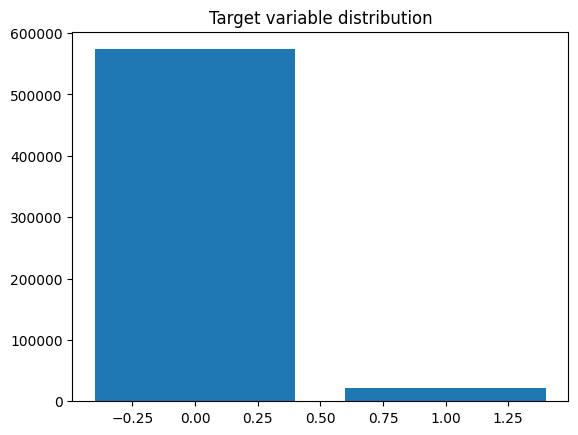

In [25]:
#go.Bar 함수가 사라져서 plt 라이브러리 이용
target_counts = train["target"].value_counts()

plt.bar(target_counts.index.values, target_counts.values)
plt.title('Target variable distribution')
plt.show()

- 현재 타겟 변수가 꽤 불균형한 것으로 보입니다. 

## Datatype check

- 학습 세트가 어떤 종류의 데이터 타입으로 구성되어 있는지를 확인합니다. 



In [27]:
#train 데이터의 colume에 대한 데이터 타입 파악
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

- train 데이터 셋을 총 59개의 열로 구성되어 있으며 int64형 49개, fliat64형이 10개 입니다. 

- 또한 칼럼에서 _bin, _cat, _reg 와같은 접미사는 데이터 타입에 대한 정보를 제공합니다. 

In [34]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

# Correlation plots

- feature간의 선형 상관관계를 확인합니다. 


## Correlation of float features

<Axes: title={'center': 'Pearson correlation of continuous features'}>

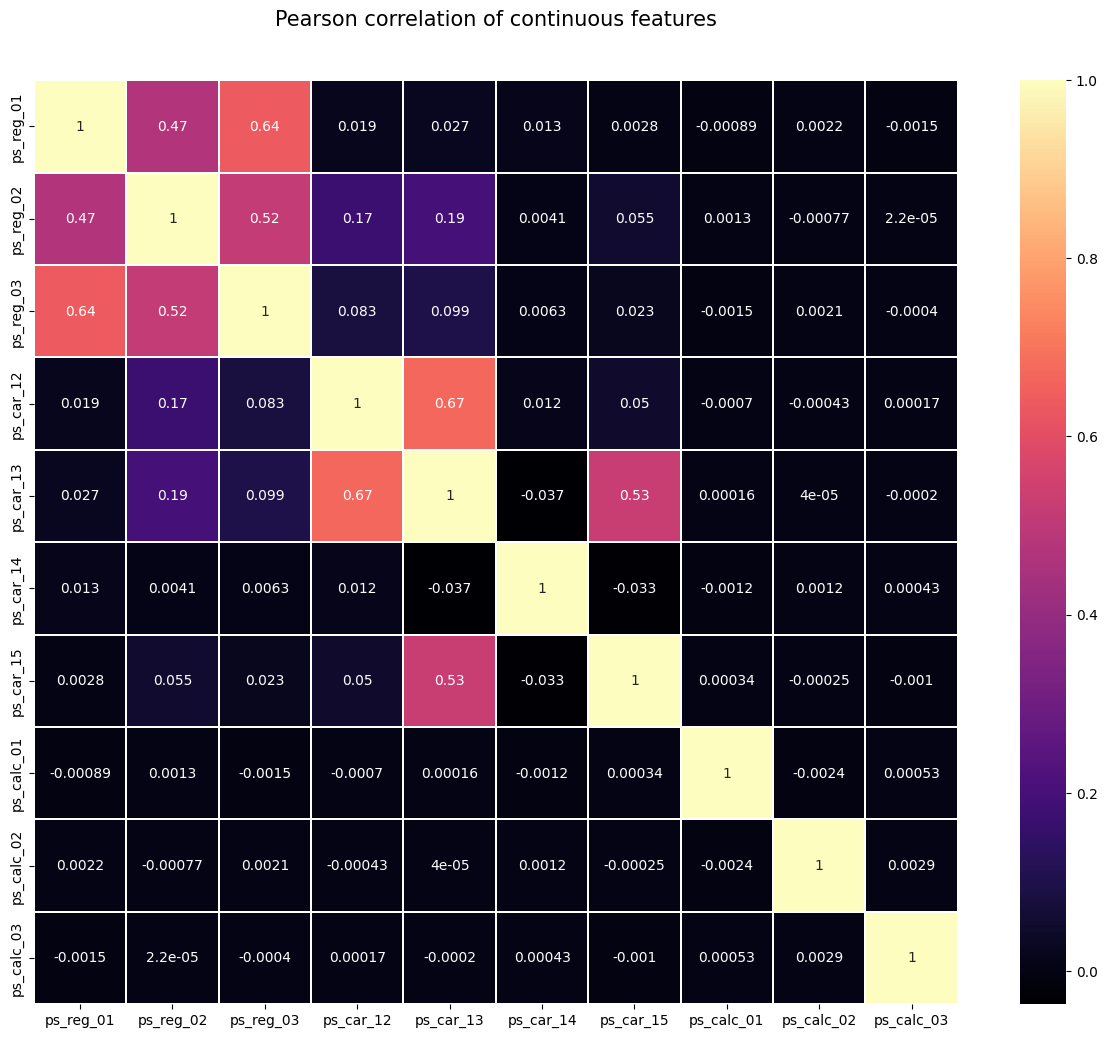

In [35]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

양의 선형 상관 관계가 나타나는 특성 쌍
- (ps_reg_01, ps_reg_03) : 0.64

- (ps_reg_02, ps_reg_03) : 0.52

- (ps_car_12, ps_car_13) : 0.67

- (ps_car_13, ps_car_15) : 0.53

##Correlation of integer features


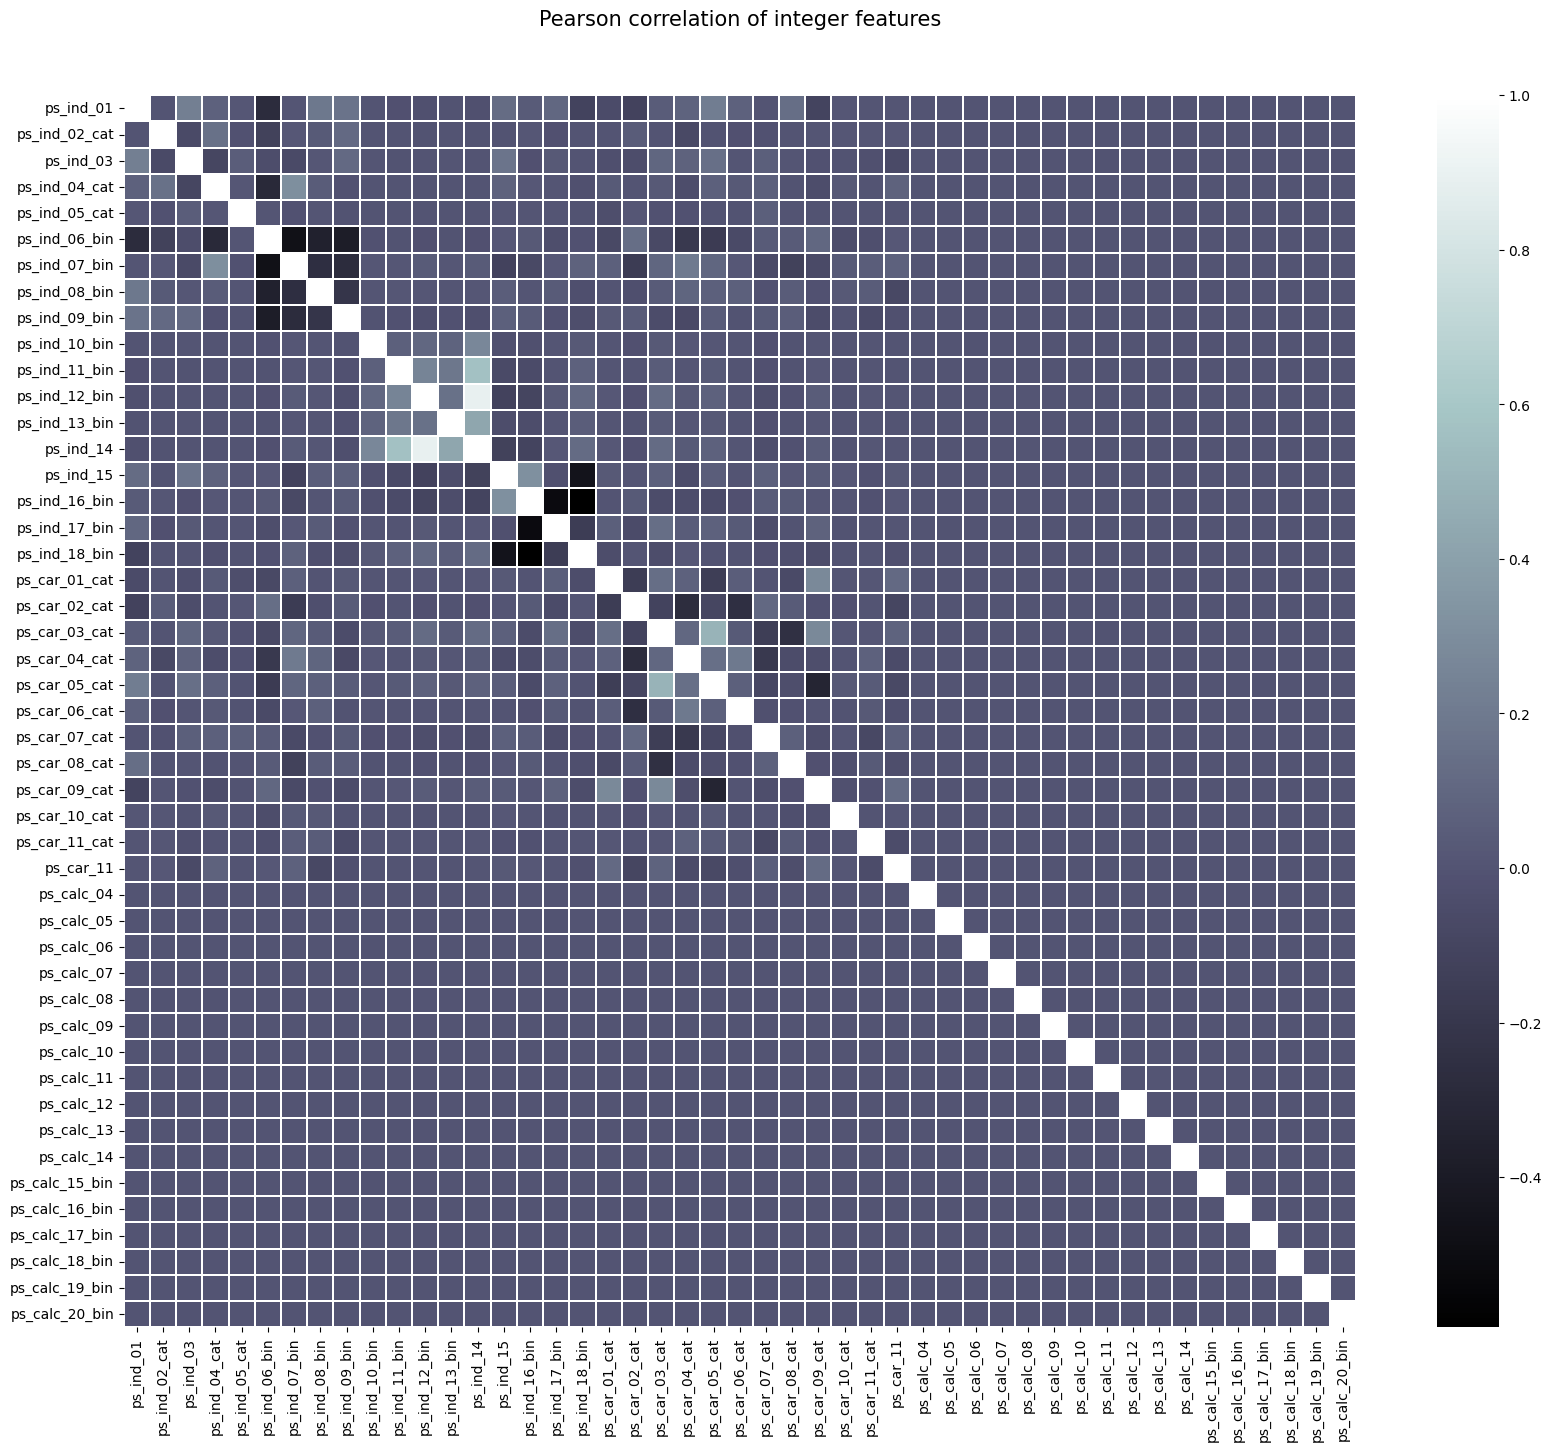

In [41]:
plt.figure(figsize=(21, 16))
plt.title('Pearson correlation of integer features', y=1.05, size=15)
colormap = plt.cm.bone
sns.heatmap(train_int.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
